In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("atharvaingle/crop-recommendation-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/ashishshirsath/.cache/kagglehub/datasets/atharvaingle/crop-recommendation-dataset/versions/1


In [2]:
path

'/Users/ashishshirsath/.cache/kagglehub/datasets/atharvaingle/crop-recommendation-dataset/versions/1'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,confusion_matrix,classification_report

In [4]:
data=pd.read_csv('Crop_recommendation.csv')

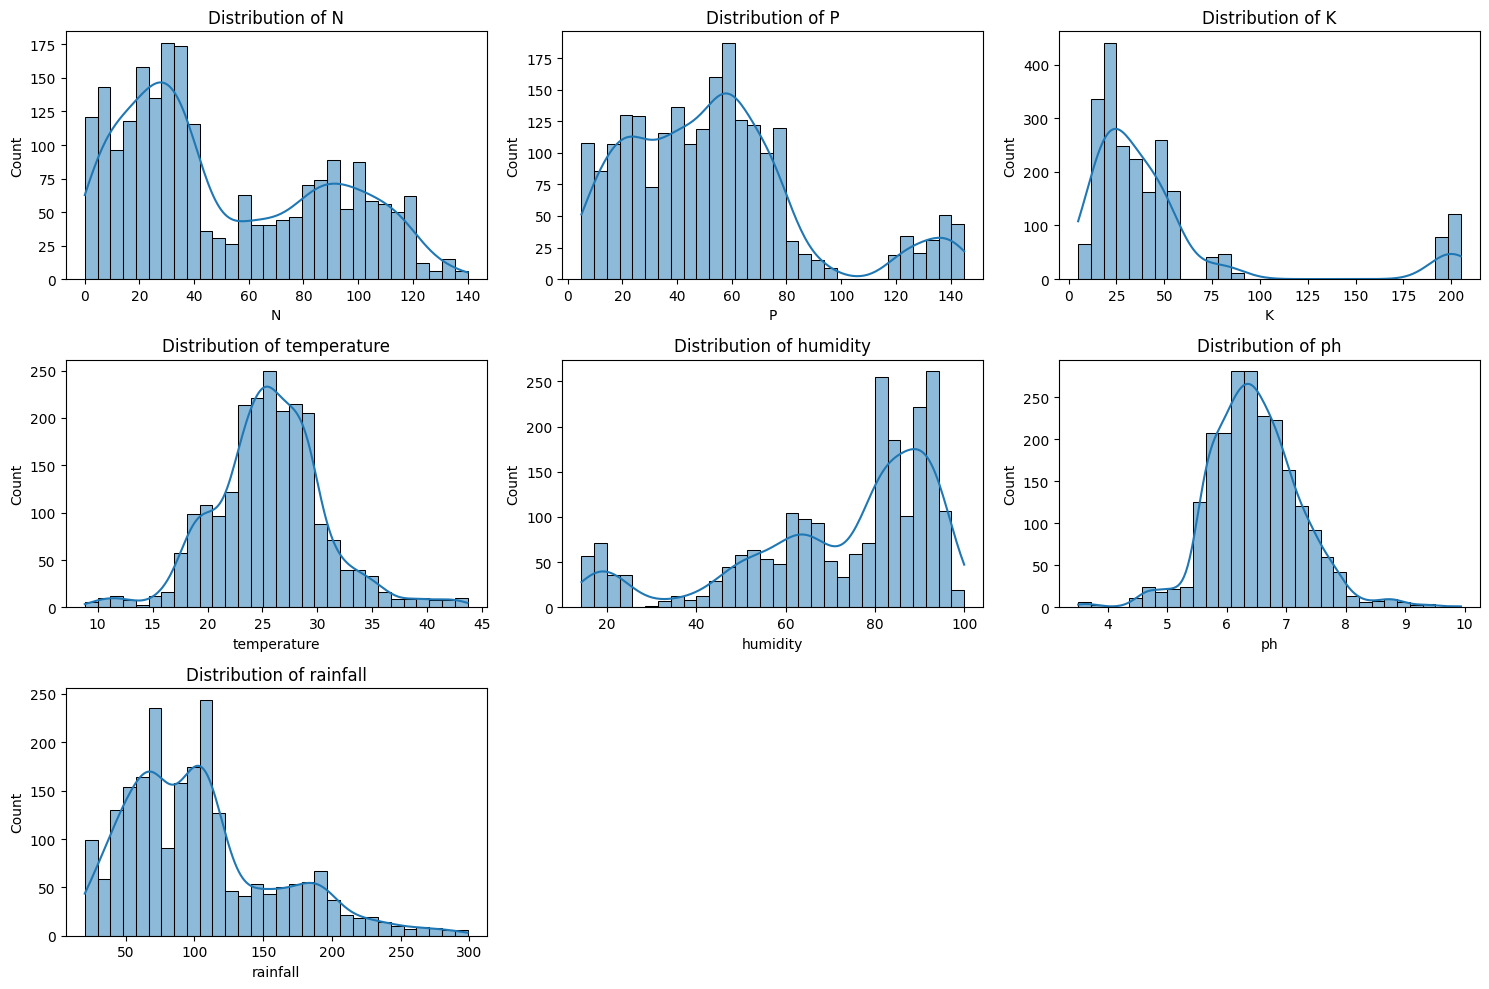

In [5]:
num_features = ['N','P','K','temperature','humidity','ph','rainfall']

plt.figure(figsize=(15,10))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

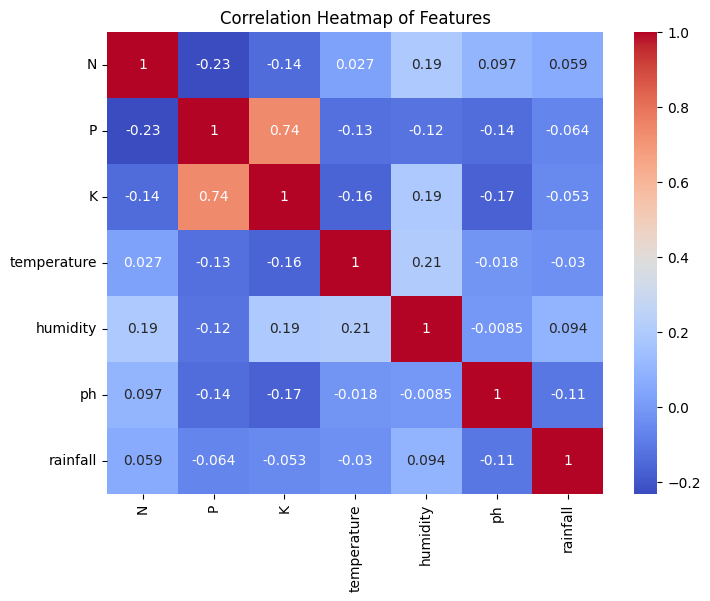

In [6]:
plt.figure(figsize=(8,6))
sns.heatmap(data[num_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Features")
plt.show()

In [7]:
def feature_engineer(data):
    data['NPK'] = (data['N'] + data['P'] + data['K']) / 3
    data['THI'] = data['temperature'] * data['humidity'] / 100
    data['rainfall_level'] = pd.cut(data['rainfall'],
                              bins=[0, 50, 100, 200, 300],
                              labels=['Low', 'Medium', 'High', 'Very High'])
    def ph_category(p):
        if p < 5.5:
            return 'Acidic'
        elif p <= 7.5:
            return 'Neutral'
        else:
            return 'Alkaline'

    data['ph_category'] = data['ph'].apply(ph_category)
    data['temp_rain_interaction'] = data['temperature'] * data['rainfall']
    data['ph_rain_interaction'] = data['ph'] * data['rainfall']

    return data

In [8]:
data_fe = feature_engineer(data)
data_fe.head()

,N,P,K,temperature,humidity,ph,rainfall,label,NPK,THI,rainfall_level,ph_category,temp_rain_interaction,ph_rain_interaction
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,58.333333,17.121963,Very High,Neutral,4237.241986,1319.686807
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,61.333333,17.485957,Very High,Neutral,4934.395694,1595.223513
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,53.000000,18.937446,Very High,Alkaline,6072.354751,2069.534380
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,49.666667,21.234829,Very High,Neutral,6433.734530,1695.288324
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,54.000000,16.427204,Very High,Alkaline,5288.545993,2004.132110


In [9]:
labels = data['label'].unique()
print("Unique labels:", labels)

Unique labels: ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


In [10]:
label_mapping = {label: i+1 for i, label in enumerate(labels)}
print("Label mapping (label → integer):")
print(label_mapping)



Label mapping (label → integer):
{'rice': 1, 'maize': 2, 'chickpea': 3, 'kidneybeans': 4, 'pigeonpeas': 5, 'mothbeans': 6, 'mungbean': 7, 'blackgram': 8, 'lentil': 9, 'pomegranate': 10, 'banana': 11, 'mango': 12, 'grapes': 13, 'watermelon': 14, 'muskmelon': 15, 'apple': 16, 'orange': 17, 'papaya': 18, 'coconut': 19, 'cotton': 20, 'jute': 21, 'coffee': 22}


In [11]:
rainfall_levels = data['rainfall_level'].unique()
rainfall_mapping = {level: i+1 for i, level in enumerate(rainfall_levels)}

# pH categories → integer
ph_categories = data['ph_category'].unique()
ph_mapping = {ph: i+1 for i, ph in enumerate(ph_categories)}

# Display mappings
print("Label mapping:", label_mapping)
print("Rainfall mapping:", rainfall_mapping)
print("pH mapping:", ph_mapping)

Label mapping: {'rice': 1, 'maize': 2, 'chickpea': 3, 'kidneybeans': 4, 'pigeonpeas': 5, 'mothbeans': 6, 'mungbean': 7, 'blackgram': 8, 'lentil': 9, 'pomegranate': 10, 'banana': 11, 'mango': 12, 'grapes': 13, 'watermelon': 14, 'muskmelon': 15, 'apple': 16, 'orange': 17, 'papaya': 18, 'coconut': 19, 'cotton': 20, 'jute': 21, 'coffee': 22}
Rainfall mapping: {'Very High': 1, 'High': 2, 'Medium': 3, 'Low': 4}
pH mapping: {'Neutral': 1, 'Alkaline': 2, 'Acidic': 3}


In [12]:
data_fe['label'] = data['label'].map(label_mapping)
data_fe['rainfall_level'] = data['rainfall_level'].map(rainfall_mapping)
data_fe['ph_category'] = data['ph_category'].map(ph_mapping)

data_fe.head()


,N,P,K,temperature,humidity,ph,rainfall,label,NPK,THI,rainfall_level,ph_category,temp_rain_interaction,ph_rain_interaction
0,90,42,43,20.879744,82.002744,6.502985,202.935536,1,58.333333,17.121963,1,1,4237.241986,1319.686807
1,85,58,41,21.770462,80.319644,7.038096,226.655537,1,61.333333,17.485957,1,1,4934.395694,1595.223513
2,60,55,44,23.004459,82.320763,7.840207,263.964248,1,53.000000,18.937446,1,2,6072.354751,2069.534380
3,74,35,40,26.491096,80.158363,6.980401,242.864034,1,49.666667,21.234829,1,1,6433.734530,1695.288324
4,78,42,42,20.130175,81.604873,7.628473,262.717340,1,54.000000,16.427204,1,2,5288.545993,2004.132110


In [13]:
X=data.drop('label',axis=1)
y=data['label']

In [14]:
X

,N,P,K,temperature,humidity,ph,rainfall,NPK,THI,rainfall_level,ph_category,temp_rain_interaction,ph_rain_interaction
0,90,42,43,20.879744,82.002744,6.502985,202.935536,58.333333,17.121963,1,1,4237.241986,1319.686807
1,85,58,41,21.770462,80.319644,7.038096,226.655537,61.333333,17.485957,1,1,4934.395694,1595.223513
2,60,55,44,23.004459,82.320763,7.840207,263.964248,53.000000,18.937446,1,2,6072.354751,2069.534380
3,74,35,40,26.491096,80.158363,6.980401,242.864034,49.666667,21.234829,1,1,6433.734530,1695.288324
4,78,42,42,20.130175,81.604873,7.628473,262.717340,54.000000,16.427204,1,2,5288.545993,2004.132110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,57.666667,17.781912,2,1,4759.847920,1205.322514
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,47.000000,15.528055,2,1,3507.323409,778.667169
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,60.333333,16.222630,2,1,4182.591541,1102.785254
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,61.000000,13.695127,2,1,3341.202503,859.551422


In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [17]:
X

,N,P,K,temperature,humidity,ph,rainfall,NPK,THI,rainfall_level,ph_category,temp_rain_interaction,ph_rain_interaction
0,90,42,43,20.879744,82.002744,6.502985,202.935536,58.333333,17.121963,1,1,4237.241986,1319.686807
1,85,58,41,21.770462,80.319644,7.038096,226.655537,61.333333,17.485957,1,1,4934.395694,1595.223513
2,60,55,44,23.004459,82.320763,7.840207,263.964248,53.000000,18.937446,1,2,6072.354751,2069.534380
3,74,35,40,26.491096,80.158363,6.980401,242.864034,49.666667,21.234829,1,1,6433.734530,1695.288324
4,78,42,42,20.130175,81.604873,7.628473,262.717340,54.000000,16.427204,1,2,5288.545993,2004.132110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,57.666667,17.781912,2,1,4759.847920,1205.322514
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,47.000000,15.528055,2,1,3507.323409,778.667169
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,60.333333,16.222630,2,1,4182.591541,1102.785254
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,61.000000,13.695127,2,1,3341.202503,859.551422


In [21]:
import joblib

# Load encoders
label_enc = joblib.load("label_encoder.pkl")
rainfall_enc = joblib.load("rainfall_encoder.pkl")
ph_enc = joblib.load("ph_encoder.pkl")

# Label mapping: original string -> encoded integer
label_mapping = {cls: int(label_enc.transform([cls])[0]) for cls in label_enc.classes_}
print("Label mapping (label → encoded):")
print(label_mapping)

# Rainfall level mapping: category string -> encoded integer
rainfall_mapping = {cls: int(rainfall_enc.transform([cls])[0]) for cls in rainfall_enc.classes_}
print("\nRainfall level mapping (category → encoded):")
print(rainfall_mapping)

# pH category mapping: category string -> encoded integer
ph_mapping = {cls: int(ph_enc.transform([cls])[0]) for cls in ph_enc.classes_}
print("\npH category mapping (category → encoded):")
print(ph_mapping)


Label mapping (label → encoded):
{np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6, np.int64(7): 7, np.int64(8): 8, np.int64(9): 9, np.int64(10): 10, np.int64(11): 11, np.int64(12): 12, np.int64(13): 13, np.int64(14): 14, np.int64(15): 15, np.int64(16): 16, np.int64(17): 17, np.int64(18): 18, np.int64(19): 19, np.int64(20): 20, np.int64(21): 21}

Rainfall level mapping (category → encoded):
{np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3}

pH category mapping (category → encoded):
{np.int64(0): 0, np.int64(1): 1, np.int64(2): 2}


In [17]:
import joblib

# load your encoder
label_encoder = joblib.load("label_encoder.pkl")

print("Label Mapping:")
for idx, cls in enumerate(label_encoder.classes_):
    print(f"{idx} -> {cls}")


FileNotFoundError: [Errno 2] No such file or directory: 'label_encoder.pkl'

In [18]:
rfc=RandomForestClassifier(n_estimators=5)
rfc.fit(X_train,y_train)

,n_estimators,5
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
rfc.score(X_train,y_train)

0.9994318181818181

In [20]:
y_pred_rfc=rfc.predict(X_test)

In [21]:
print('accuracy score:',accuracy_score(y_test,y_pred_rfc))
print('mean_squared_error:',mean_squared_error(y_test,y_pred_rfc))
print('classification report:',classification_report(y_test,y_pred_rfc))

accuracy score: 0.9818181818181818
mean_squared_error: 2.8181818181818183
classification report:               precision    recall  f1-score   support

           1       0.94      0.89      0.92        19
           2       0.91      1.00      0.95        21
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        20
           5       1.00      0.87      0.93        23
           6       0.96      0.96      0.96        24
           7       1.00      1.00      1.00        19
           8       0.95      0.95      0.95        20
           9       0.92      1.00      0.96        11
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00      1.00     

In [23]:
X_train=pd.DataFrame(X_train,columns=X.columns)
X_train

,N,P,K,temperature,humidity,ph,rainfall,NPK,THI,rainfall_level,ph_category,temp_rain_interaction,ph_rain_interaction
0,-0.903427,-1.126162,-0.668507,-1.804692,0.936586,0.193474,0.005150,-1.308849,-0.491164,-0.794672,-0.369892,-0.605443,0.064022
1,-0.367051,0.770359,-0.570590,0.386000,-0.100470,0.863918,-0.605291,-0.214331,0.084755,0.437594,-0.369892,-0.459637,-0.460886
2,-1.171614,0.589738,-0.453089,0.381678,-0.382775,1.050298,-1.045807,-0.587463,-0.164569,1.669861,-0.369892,-0.894386,-0.929874
3,1.349349,0.499427,-0.002670,-0.043047,0.157688,-0.599105,0.252872,0.830436,0.074278,-0.794672,-0.369892,0.220308,0.116843
4,-1.359346,-1.096058,-0.355172,1.944562,-1.071303,-0.254526,-0.088658,-1.308849,-0.216150,0.437594,-0.369892,0.554558,-0.127720
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,-1.091158,-1.457300,-0.844757,-0.858104,0.898979,1.735467,0.187893,-1.644668,0.124887,-0.794672,1.608862,-0.143823,0.631265
1756,1.537081,1.221911,-0.022254,0.349697,0.589808,-0.114467,-0.215681,1.203567,0.666925,0.437594,-0.369892,-0.086628,-0.223514
1757,-1.064339,-0.524092,-0.335589,0.460044,-0.898381,-0.000634,-0.043736,-0.923281,-0.586087,-0.794672,-0.369892,0.118340,-0.028555
1758,-1.064339,2.125016,3.052342,-2.387631,0.386340,-0.148467,-0.569037,2.322961,-1.121215,0.437594,-0.369892,-1.080198,-0.578334


In [24]:
import joblib

filename = 'crop_recommendation2.pkl'
joblib.dump(rfc, filename)

print(f"Model saved to {filename}")

Model saved to crop_recommendation2.pkl
